In [1]:
# =============================================================================
#  Spotify Dataset gener oriented breakdown and classification 
# =============================================================================
#  Author : Matan Ziv
#  Date   : 18-Jun-2025
# =============================================================================

# -----------------------------
# 0. House-keeping
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                # visualisation library as required
from pathlib import Path

plt.style.use("default")             # keep default style; avoid seaborn themes
sns.set_context("notebook")

RANDOM_STATE = 42                    # reproducibility

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# -----------------------------
# 1. Load the dataset
# -----------------------------
DATA_PATH = Path(r"C:\Users\matan\Desktop\Code\DataSets\SpotifyFeatures/SpotifyFeatures.csv")
assert DATA_PATH.exists(), f"File not found: {DATA_PATH}"

spotifydf = pd.read_csv(DATA_PATH)
print(f"Loaded {spotifydf.shape[0]:,} rows × {spotifydf.shape[1]} columns")

# Peek at the data ------------------------------------------------------------
print("\nfirst 5 tracks:")
display(spotifydf.head())                   # first 5 tracks
print("\n Information: how many sells at each column are null and whats the data type")
spotifydf.info(show_counts=True)            # dtypes & missing-value counts
print("\n More details about the fildes: min, max, std, and X%")
display(spotifydf.describe().T)             # numeric summary (transposed for width)

print("Lets unsersted the genres better... it will be the problem we will try to solve")


Loaded 232,725 rows × 18 columns

first 5 tracks:


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390



 Information: how many sells at each column are null and whats the data type
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  flo

,count,mean,std,min,25%,50%,75%,max
popularity,232725.0,41.127502,18.189948,0.00000,29.0000,43.000000,55.0000,100.000
acousticness,232725.0,0.368560,0.354768,0.00000,0.0376,0.232000,0.7220,0.996
danceability,232725.0,0.554364,0.185608,0.05690,0.4350,0.571000,0.6920,0.989
duration_ms,232725.0,235122.339306,118935.909299,15387.00000,182857.0000,220427.000000,265768.0000,5552917.000
energy,232725.0,0.570958,0.263456,0.00002,0.3850,0.605000,0.7870,0.999
instrumentalness,232725.0,0.148301,0.302768,0.00000,0.0000,0.000044,0.0358,0.999
liveness,232725.0,0.215009,0.198273,0.00967,0.0974,0.128000,0.2640,1.000
loudness,232725.0,-9.569885,5.998204,-52.45700,-11.7710,-7.762000,-5.5010,3.744
speechiness,232725.0,0.120765,0.185518,0.02220,0.0367,0.050100,0.1050,0.967
tempo,232725.0,117.666585,30.898907,30.37900,92.9590,115.778000,139.0540,242.903


Lets unsersted the genres better... it will be the problem we will try to solve


The DatSet contain: 27 genres


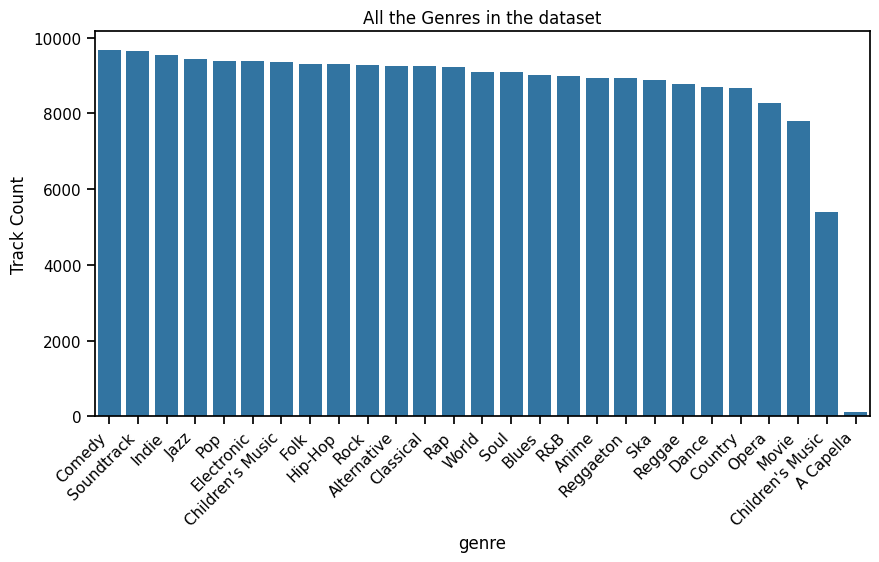

Genres by track count + summary stats


popularity                      acousticness               \
                      count   mean median    std        count  mean median   
genre                                                                        
Comedy                 9681  21.34   20.0   8.43         9681  0.79   0.82   
Soundtrack             9646  33.95   33.0   8.64         9646  0.72   0.84   
Indie                  9543  54.70   54.0   7.36         9543  0.33   0.22   
Jazz                   9441  40.82   40.0   9.59         9441  0.50   0.52   
Pop                    9386  66.59   66.0   7.25         9386  0.22   0.12   
Electronic             9377  38.06   37.0   9.74         9377  0.12   0.02   
Children’s Music       9353  54.66   54.0   7.85         9353  0.16   0.04   
Folk                   9299  49.94   49.0   8.22         9299  0.46   0.46   
Hip-Hop                9295  58.42   57.0   8.27         9295  0.18   0.11   
Rock                   9272  59.62   59.0   7.47         9272  0.20   0.07   
Alternative            9263  50.21   49.0   7.66         9263  0.16   0.03   
Classical              9256  29.28   32.0  14.13         9256  0.87   0.97   
Rap                    9232  60.53   59.0   8.18         9232  0.17   0.10   
World                  9096  35.52   34.0   9.40         9096  0.39   0.28   
Soul                   9089  47.03   46.0   9.24         9089  0.36   0.29   
Blues                  9023  34.74   33.0   9.76         9023  0.33   0.23   
R&B                    8992  52.31   51.0   9.25         8992  0.29   0.21   
Anime                  8936  24.26   23.0   9.65         8936  0.29   0.07   
Reggaeton              8927  37.74   35.0  13.54         8927  0.22   0.17   
Ska                    8874  28.61   27.0  10.76         8874  0.10   0.02   
Reggae                 8771  35.59   34.0  10.78         8771  0.19   0.11   
Dance                  8701  57.28   57.0  11.21         8701  0.15   0.08   
Country                8664  46.10   45.0   9.75         8664  0.27   0.18   
Opera                  8280  13.34   11.0   8.46         8280  0.95   0.96   
Movie                  7806  12.17    7.0  13.61         7806  0.70   0.79   
Children's Music       5403   4.25    0.0   7.99         5403  0.59   0.66   
A Capella               119   9.30    8.0   7.87          119  0.83   0.90   

                       danceability        ... speechiness       tempo  \
                   std        count  mean  ...      median   std count   
genre                                      ...                           
Comedy            0.13         9681  0.56  ...        0.93  0.21  9681   
Soundtrack        0.29         9646  0.27  ...        0.04  0.02  9646   
Indie             0.32         9543  0.57  ...        0.04  0.07  9543   
Jazz              0.34         9441  0.59  ...        0.04  0.08  9441   
Pop               0.25         9386  0.64  ...        0.06  0.11  9386   
Electronic        0.20         9377  0.62  ...        0.06  0.10  9377   
Children’s Music  0.24         9353  0.54  ...        0.05  0.09  9353   
Folk              0.33         9299  0.53  ...        0.04  0.04  9299   
Hip-Hop           0.19         9295  0.72  ...        0.19  0.13  9295   
Rock              0.25         9272  0.54  ...        0.04  0.04  9272   
Alternative       0.24         9263  0.54  ...        0.05  0.09  9263   
Classical         0.26         9256  0.31  ...        0.04  0.04  9256   
Rap               0.19         9232  0.70  ...        0.16  0.13  9232   
World             0.36         9096  0.44  ...        0.04  0.04  9096   
Soul              0.29         9089  0.62  ...        0.05  0.08  9089   
Blues             0.31         9023  0.53  ...        0.04  0.06  9023   
R&B               0.26         8992  0.64  ...        0.07  0.11  8992   
Anime             0.36         8936  0.47  ...        0.05  0.05  8936   
Reggaeton         0.18         8927  0.73  ...        0.09  0.10  8927   
Ska               0.17         8874  0.53  ...  

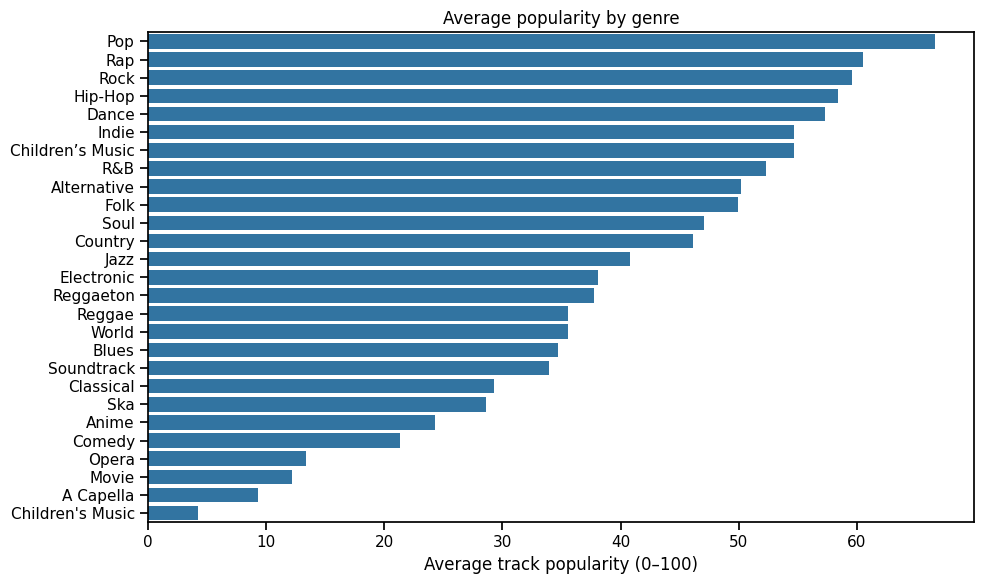

In [3]:
# -----------------------------------------------------------------------------
# 2. Genre-level Group by representations
# -----------------------------------------------------------------------------

genre_counts = spotifydf['genre'].value_counts().sort_values(ascending=False)
print(f"The DatSet contain: {genre_counts.count()} genres")
# print("Genre traks count", genre_counts.values)

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("All the Genres in the dataset")
plt.ylabel("Track Count")
# plt.tight_layout()
plt.show()

# Grab the numeric columns so we can summarise them in one shot
numeric_cols = spotifydf.select_dtypes(include="number").columns

# For every genre, compute:
#   • track count
#   • mean, median, and std-dev for every numeric feature
# The result is a tidy MultiIndex column frame.
genre_stats = (
    spotifydf
    .groupby("genre")[numeric_cols]
    .agg(["count", "mean", "median", "std"])
    .round(2)                                 # tidy up decimals
    .sort_values(("popularity", "count"),     # sort by #tracks, most first
                 ascending=False)
)

print("Genres by track count + summary stats")
display(genre_stats)

# Track count per genre  (same as value_counts but with groupby syntax)
genre_sizes = (
    spotifydf
    .groupby("genre")
    .size()
    .sort_values(ascending=False)
    .rename("track_count")
)

# Average popularity per genre
popularity_by_genre = (
    spotifydf
    .groupby("genre")["popularity"]
    .mean()
    .sort_values(ascending=False)
)

# Combine for one neat table
genre_overview = (
    pd.concat([genre_sizes, popularity_by_genre], axis=1)
      .rename(columns={"popularity": "avg_popularity"})
)


plt.figure(figsize=(10, 6))
sns.barplot(y=popularity_by_genre.index, x=popularity_by_genre.values)
plt.title("Average popularity by genre")
plt.xlabel("Average track popularity (0–100)")
plt.ylabel("")
plt.tight_layout()
plt.show()



Missing-value counts:
track_name    1
dtype: int64




#############################################################################


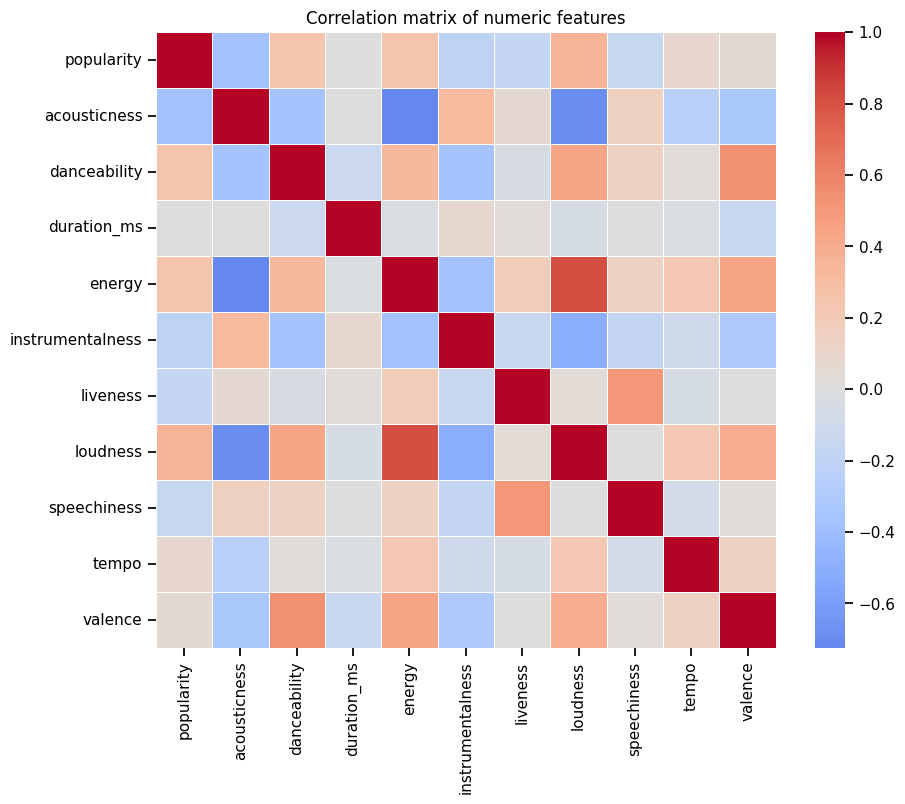





#############################################################################


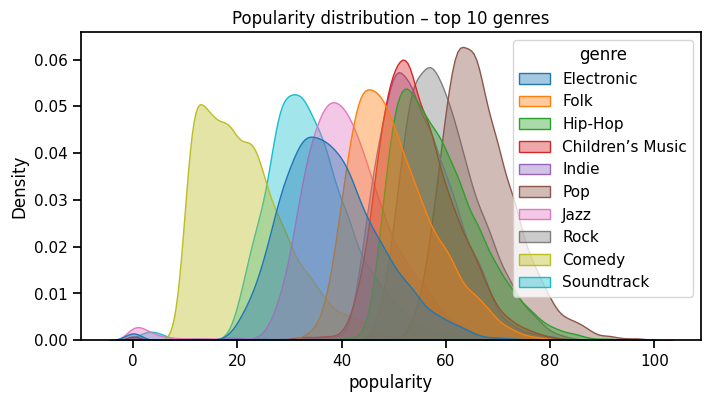

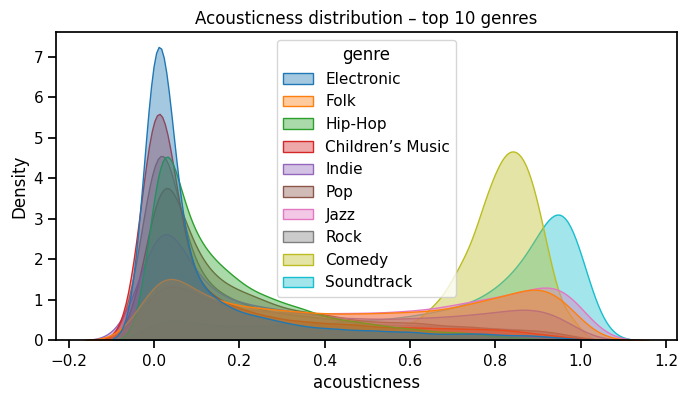

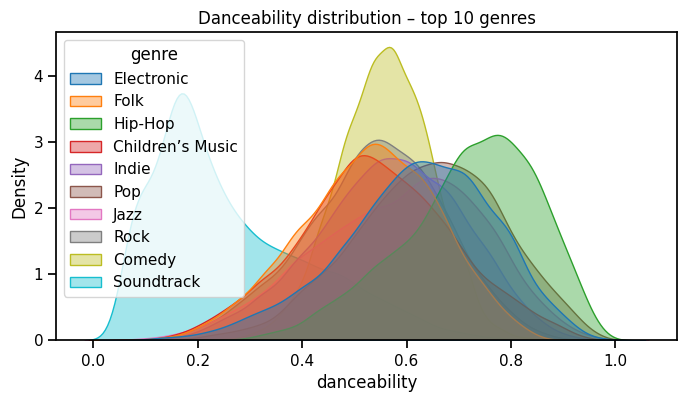

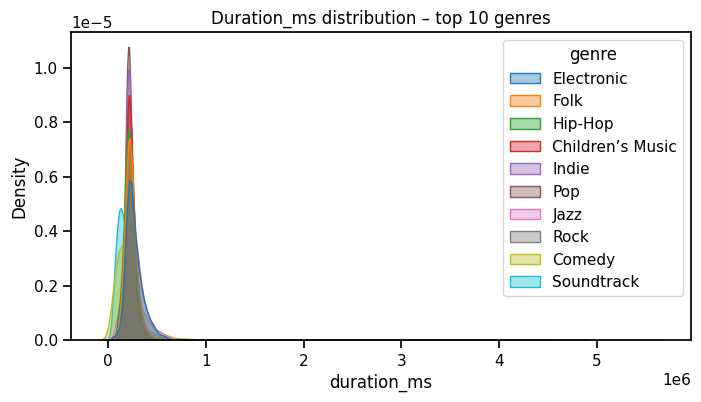

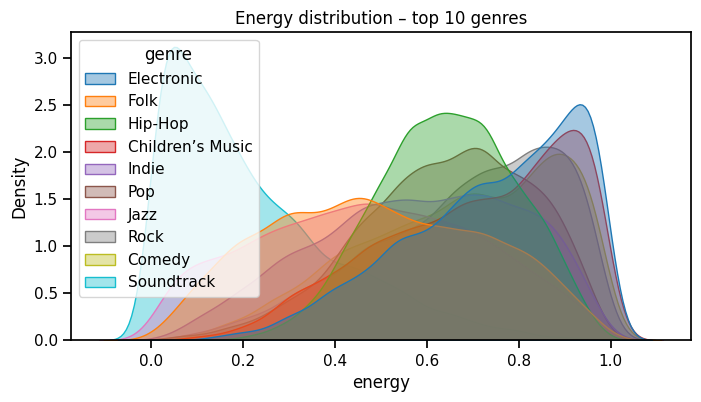

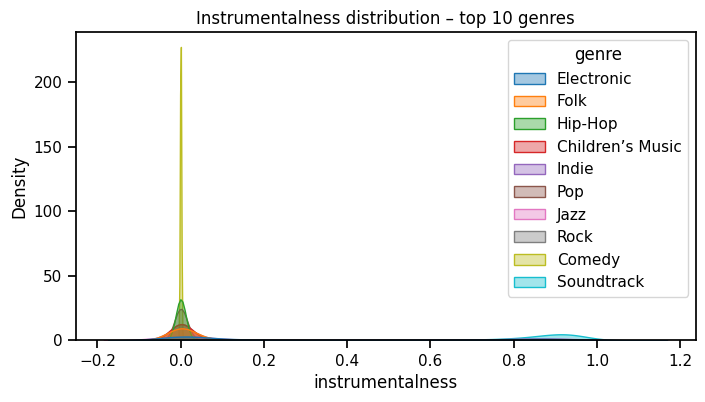

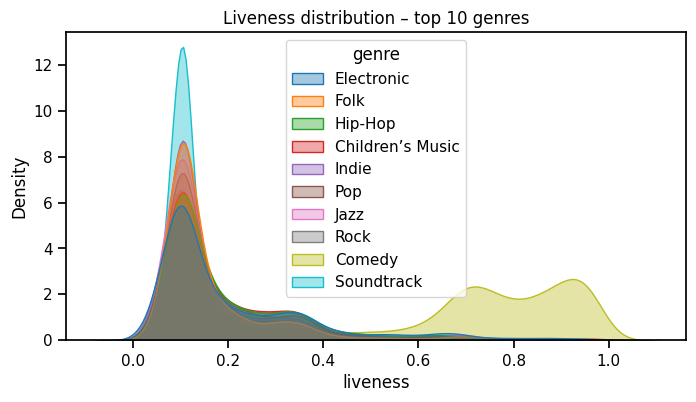

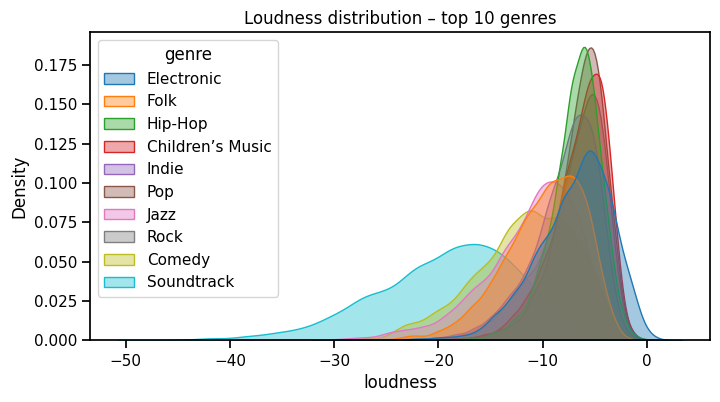

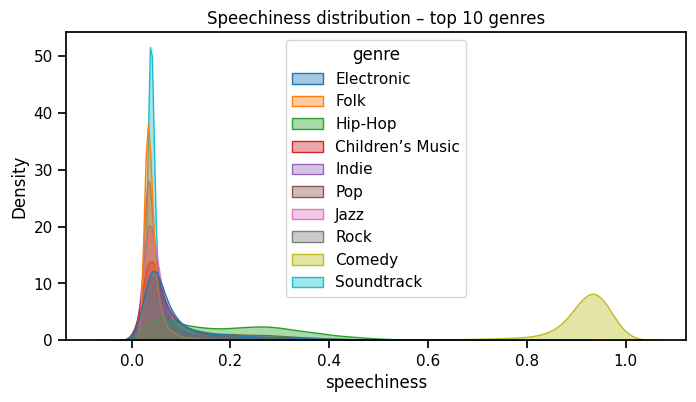

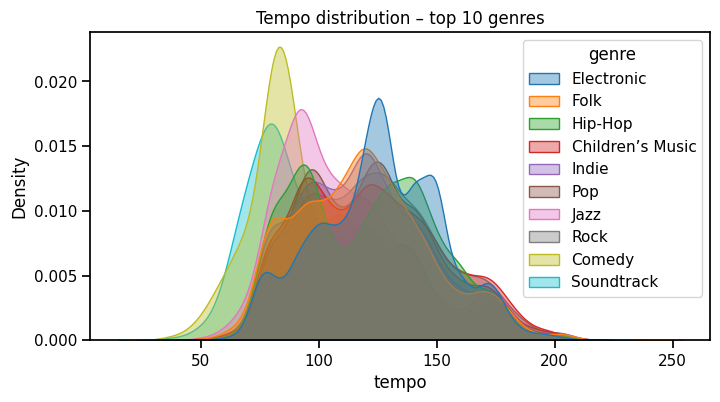

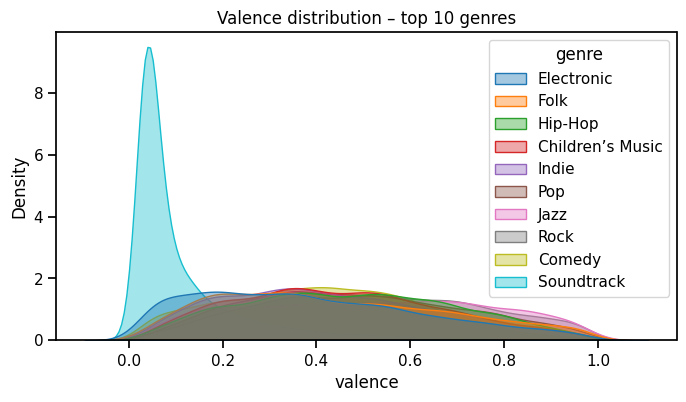




#############################################################################

Top 15 consistently popular artists (≥25 tracks), JUST 4 FUN:
     artist_name mean_popularity  n_tracks
     Post Malone            76.0        85
      Juice WRLD            75.5        40
          Offset            74.7        58
          Khalid            74.4        32
    XXXTENTACION            73.0       106
    Metro Boomin            73.0        41
         6ix9ine            72.9        26
      Ed Sheeran            72.9        47
   Ariana Grande            72.6       142
Hailee Steinfeld            72.3        25
       Bad Bunny            72.0        34
        Lil Peep            71.7        56
   Alec Benjamin            71.7        25
  Camila Cabello            71.0        50
      Marshmello            70.8        34


In [4]:
# -----------------------------
# 2. Graphs Data Analysis
# -----------------------------
# 2.1 Missing values ----------------------------------------------------------
na_counts = spotifydf.isna().sum()# if spotifydf.isna().sum() is not None else 0.0
print("\nMissing-value counts:")
print(na_counts[na_counts > 0] if na_counts.any() else "No missing values")

print("\n\n\n\n#############################################################################")

# 2.2 Correlation heat-map ----------------------------------------------------
numeric_cols = spotifydf.select_dtypes("number").columns
corr = spotifydf[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
    center=0,
    linewidths=.5
)
plt.title("Correlation matrix of numeric features")
plt.show()

print("\n\n\n\n#############################################################################")
# 2.3 Distributions per genre -------------------------------------------------
top_genres = (spotifydf["genre"]
              .value_counts()
              .head(10)
              .index)

# Automatically select all numerical columns
numeric_cols = spotifydf.select_dtypes(include='number').columns

for col in numeric_cols:
# for col in ["danceability", "energy", "acousticness", "valence", "popularity"]:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        data=spotifydf[spotifydf["genre"].isin(top_genres)],
        x=col,
        hue="genre",
        common_norm=False,
        fill=True,
        alpha=.4
    )
    plt.title(f"{col.capitalize()} distribution – top 10 genres")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

print("\n\n\n#############################################################################")

# 2.4 Popularity leaderboard --------------------------------------------------
leaderboard = (spotifydf.groupby("artist_name", as_index=False)
                 .agg(mean_popularity=("popularity", "mean"),
                      n_tracks=("track_id", "count"))
                 .query("n_tracks >= 25")      # keep artists with ≥25 tracks
                 .sort_values("mean_popularity", ascending=False)
                 .head(15))

print("\nTop 15 consistently popular artists (≥25 tracks), JUST 4 FUN:")
#display(leaderboard.style.format({"mean_popularity": "{:.1f}"}))
print(leaderboard.to_string(index=False, formatters={"mean_popularity": "{:.1f}".format}))




In [5]:
# -----------------------------
# 3. Feature Engineering
# -----------------------------
# 3.1 New domain-aware features ----------------------------------------------
spotifydf_fe = spotifydf.copy()

# 1. Track length in minutes (more intuitive than milliseconds)
print("converting duration from milliseconds into minutes \n")
spotifydf_fe["duration_min"] = spotifydf_fe["duration_ms"] / 1000 / 60

# # 2. Loudness is negative dBFS; turn it into positive energy-adjusted measure
# print("Making a new filed energy_loudness_ratio because i saw the relations are large in the matrix\n")
# spotifydf_fe["energy_loudness_ratio"] = spotifydf_fe["energy"] / spotifydf_fe["loudness"].abs()

# 3. Is major key?  (mode 1 = major)
print("the \"mode\" options are:", spotifydf_fe["mode"].unique())
spotifydf_fe["is_major"] = (spotifydf_fe["mode"] == "Major").astype(int)
print(f"now after the encoding the \"mode\" options are{spotifydf_fe["is_major"].unique()}\n")

# 4. time_signature into ts_value = (numerator * 2) / denominator
unique_time_signatures = spotifydf_fe["time_signature"].unique()
def ts_to_value(x: pd.Series) -> pd.Series:
    """
    Convert time-signature strings or integers to
    (numerator*2)/denominator as requested.
    x looks like '3/4', parse both parts.
    """
    def _convert(val):
        if pd.isna(val):
            return np.nan
        match = re.match(r"(\d+)\s*/\s*(\d+)", str(val))
        if not match:
            return np.nan
        num, den = map(int, match.groups())
        return (num * 2) / den
    return x.apply(_convert)

print("lets see how many time signatures we got, in order to see how we want to handle it", unique_time_signatures)
spotifydf_fe["ts_value"] = ts_to_value(spotifydf_fe["time_signature"])
unique_time_signatures = spotifydf_fe["ts_value"].unique()
print("now lets see the new encoding:")
print(unique_time_signatures)
print("I like it ;)\n")

# 5. Acoustic-instrumental synergy (might be handy for genre separation)
spotifydf_fe["acoustic_instrumentalness"] = (
    spotifydf_fe["acousticness"] * spotifydf_fe["instrumentalness"]
)

# 6. Key sin and coin encoding:
print(f"those are the uniqekeys in \"keys\"{spotifydf_fe["key"].unique()}, lets give each one numeric representation and map the df")

# Sharp-note mapping (based on your dataset)
KEY_MAP = {
    "C": 0, "C#": 1,
    "D": 2, "D#": 3,
    "E": 4, "F": 5,
    "F#": 6, "G": 7,
    "G#": 8, "A": 9,
    "A#": 10, "B": 11
}

# 2. Map string key to pitch class (0–11)
spotifydf_fe["key_num"] = spotifydf_fe["key"].map(KEY_MAP)
print(f"Now those are the uniqekeys in \"keys\"{spotifydf_fe["key_num"].unique()} lets apply sin and cosin encoding")

# 3. Compute circular sin/cos encoding
spotifydf_fe["key_sin"] = np.sin(2 * np.pi * spotifydf_fe["key_num"] / 12)
spotifydf_fe["key_cos"] = np.cos(2 * np.pi * spotifydf_fe["key_num"] / 12)

# print("new uniqe keys:")
# print(spotifydf_fe["key_cos"].unique())
# print(spotifydf_fe["key_sin"].unique())


# =============================================================================
# 3-A  Compact TF-IDF mean scores  (track + artist)
# =============================================================================

# 1. Vectoriser settings you already like
_track_vec  = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", min_df=2)
_artist_vec = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", min_df=2)

# 2. Fit-transform and take the *mean* TF-IDF weight per row
spotifydf_fe["track_tfidf_mean"] = (
    _track_vec
    .fit_transform(spotifydf_fe["track_name"].fillna(""))
    .mean(axis=1)
    .A1          # flatten to 1-D array
)

spotifydf_fe["artist_tfidf_mean"] = (
    _artist_vec
    .fit_transform(spotifydf_fe["artist_name"].fillna(""))
    .mean(axis=1)
    .A1
)

# -------------------------------------------------------------------
# 3.2  Define feature groups
# -------------------------------------------------------------------

NUMERICS    = [
    "duration_min",               # ← our converted time
    "danceability", "energy", "liveness", "speechiness",
    "valence", "tempo", "acousticness",
    "instrumentalness", "loudness", "popularity",
    "ts_value", "is_major", "key_sin" ,"key_cos" ,
    "acoustic_instrumentalness", "key_sin" ,"key_cos",
    "track_tfidf_mean", "artist_tfidf_mean",
    # "energy_loudness_ratio",
]



# -------------------------------------------------------------------
# 3.3  Build the preprocessing pipeline
# -------------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        # 3)  Scaled numeric features
        ("num",
         StandardScaler(),
         NUMERICS),

    ],
    # remainder="drop",   # ignore everything else
)

# Fit-transform so you can inspect the resulting matrix immediately
X_prepared = preprocessor.fit_transform(spotifydf_fe.fillna({ 
    "track_name": "", 
    "artist_name": "" 
}))

converting duration from milliseconds into minutes 

the "mode" options are: ['Major' 'Minor']
now after the encoding the "mode" options are[1 0]

lets see how many time signatures we got, in order to see how we want to handle it ['4/4' '5/4' '3/4' '1/4' '0/4']
now lets see the new encoding:
[2.  2.5 1.5 0.5 0. ]
I like it ;)

those are the uniqekeys in "keys"['C#' 'F#' 'C' 'F' 'G' 'E' 'D#' 'G#' 'D' 'A#' 'A' 'B'], lets give each one numeric representation and map the df
Now those are the uniqekeys in "keys"[ 1  6  0  5  7  4  3  8  2 10  9 11] lets apply sin and cosin encoding


In [6]:
# -------------------------------------------------------------------
# 4. Supervised models: AdaBoost & Random-Forest setup
# -------------------------------------------------------------------
# -------------------------------------------------------
# 4-A  Choose the target you want to predict
# -------------------------------------------------------
TARGET = "genre"          # this is the problem i wanted to solve
assert TARGET in spotifydf_fe.columns, f"{TARGET} column not found!"

y = spotifydf_fe[TARGET]
X = spotifydf_fe.drop(columns=[TARGET])

# Encode the target labels as integers and print mapping
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
# genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("\nGenre to numeric label mapping:")
# for genre, label in genre_mapping.items():
#     print(f"{genre:20s} --> {label}")
    
    
# -------------------------------------------------------
# 4-B  Train / test split (stratified keeps class balance)
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# -------------------------------------------------------
# 4-C  Helper: evaluation in a single call
# -------------------------------------------------------
def evaluate(pipe, name, X_tr=X_train, X_te=X_test, y_tr=y_train, y_te=y_test):
    """
    Fit the pipeline, print CV and hold-out metrics,
    and optionally draw a confusion matrix.
    """
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    cv_res = cross_validate(pipe, X_tr, y_tr,
                            cv=cv,
                            scoring=["accuracy", "f1_macro"],
                            return_train_score=False)
    print(f"\n{name} - 4-fold CV:", 
          f"acc={cv_res['test_accuracy'].mean():.3f}  ",
          f"F1={cv_res['test_f1_macro'].mean():.3f}")

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    print("\nHold-out classification report:")
    print(classification_report(y_te, y_pred))

    # Confusion-matrix heat-map
    plt.figure(figsize=(20,20))
    cm = confusion_matrix(y_te, y_pred, labels=pipe.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=pipe.classes_,
                yticklabels=pipe.classes_)
    plt.title(f"{name} – Test Confusion Matrix")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.show()
    return pipe




AdaBoost - 4-fold CV: acc=0.204   F1=0.190

Hold-out classification report:
                  precision    recall  f1-score   support

       A Capella       0.02      0.12      0.03        24
     Alternative       0.10      0.00      0.01      1853
           Anime       0.36      0.05      0.09      1787
           Blues       0.30      0.10      0.15      1805
Children's Music       0.44      0.46      0.45      1081
Children’s Music       0.00      0.00      0.00      1871
       Classical       0.07      0.06      0.06      1851
          Comedy       0.96      0.67      0.79      1936
         Country       0.37      0.13      0.19      1733
           Dance       0.00      0.00      0.00      1740
      Electronic       0.31      0.03      0.05      1875
            Folk       0.29      0.08      0.13      1860
         Hip-Hop       0.08      0.03      0.05      1859
           Indie       0.08      0.43      0.14      1909
            Jazz       0.30      0.16      0.21     

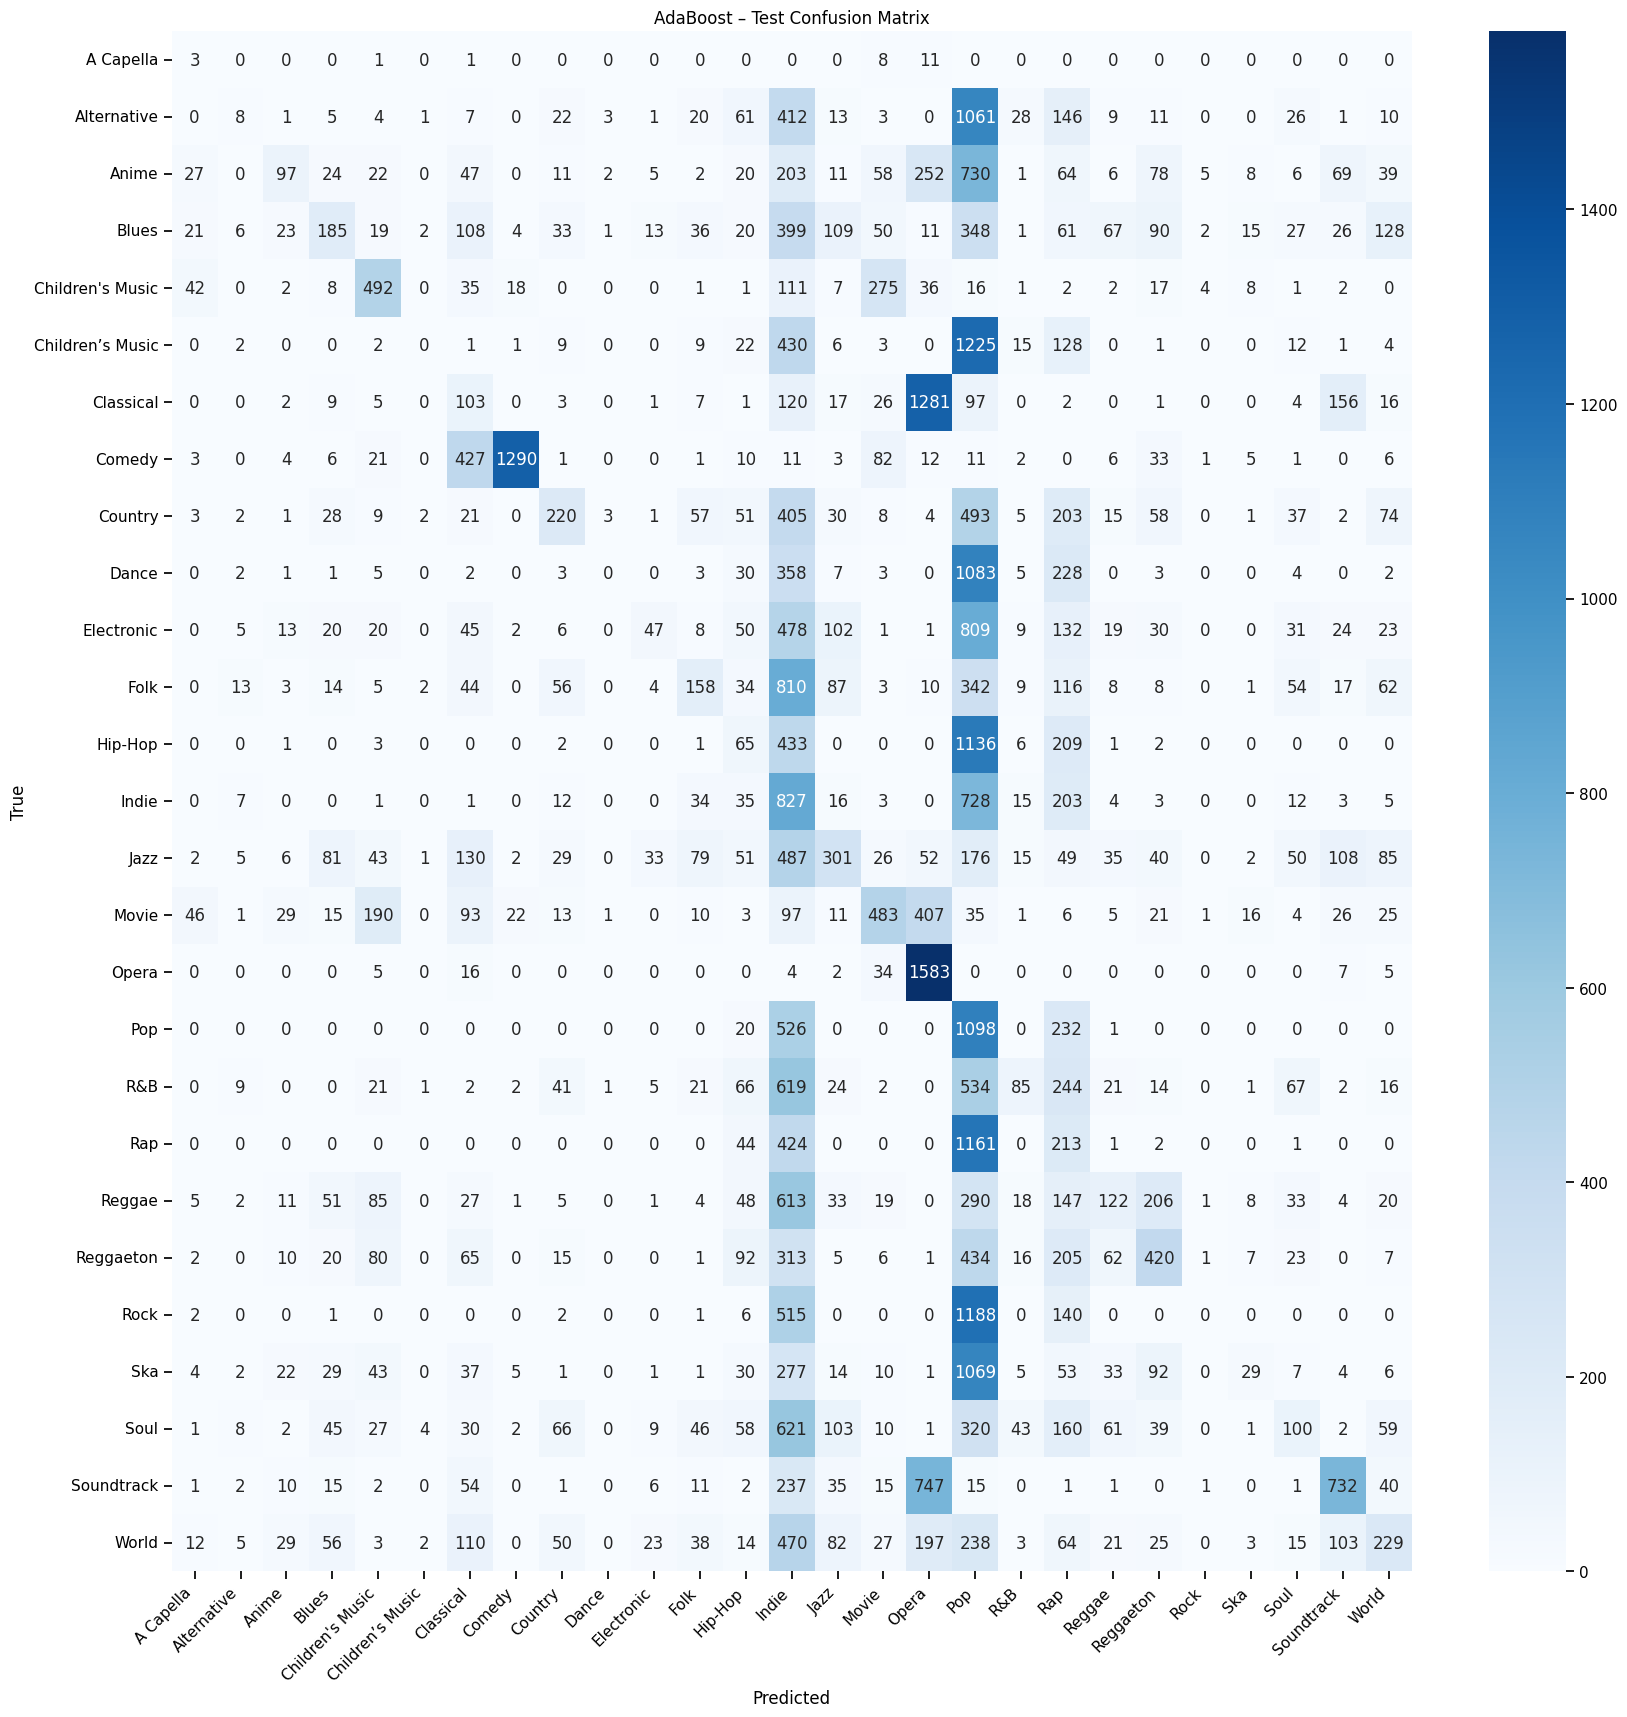

In [7]:
# -------------------------------------------------------
# 4-D  AdaBoost
# -------------------------------------------------------
ada_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf",  AdaBoostClassifier(n_estimators=300,
                                learning_rate=0.8,
                                random_state=42))
])

ada_model = evaluate(ada_pipe, "AdaBoost")

In [8]:
"""my conclusions:
    1. it seems like most of the trekes predictions are between 13-21 witch is kind of the middel of 0-26 with a shift so my theory is that addabust outputs something in the middle when the output is ambiguous 
    2. The pop genre is a very popular choice by the model witch tells me that pop is very kind of the middle of the genres and the model is not sure what to choose so it chooses pop, it dosent have unique features that make it pop, it is just a mix of all the genres. 
""" 


'my conclusions:\n    1. it seems like most of the trekes predictions are between 13-21 witch is kind of the middel of 0-26 with a shift so my theory is that addabust outputs something in the middle when the output is ambiguous \n    2. The pop genre is a very popular choice by the model witch tells me that pop is very kind of the middle of the genres and the model is not sure what to choose so it chooses pop, it dosent have unique features that make it pop, it is just a mix of all the genres. \n'


Random-Forest - 4-fold CV: acc=0.410   F1=0.415

Hold-out classification report:
                  precision    recall  f1-score   support

       A Capella       1.00      0.25      0.40        24
     Alternative       0.12      0.09      0.10      1853
           Anime       0.69      0.65      0.67      1787
           Blues       0.41      0.41      0.41      1805
Children's Music       0.87      0.85      0.86      1081
Children’s Music       0.03      0.03      0.03      1871
       Classical       0.74      0.69      0.71      1851
          Comedy       0.98      0.94      0.96      1936
         Country       0.42      0.48      0.45      1733
           Dance       0.10      0.10      0.10      1740
      Electronic       0.53      0.56      0.54      1875
            Folk       0.20      0.22      0.21      1860
         Hip-Hop       0.14      0.16      0.15      1859
           Indie       0.06      0.05      0.06      1909
            Jazz       0.40      0.38      0.39

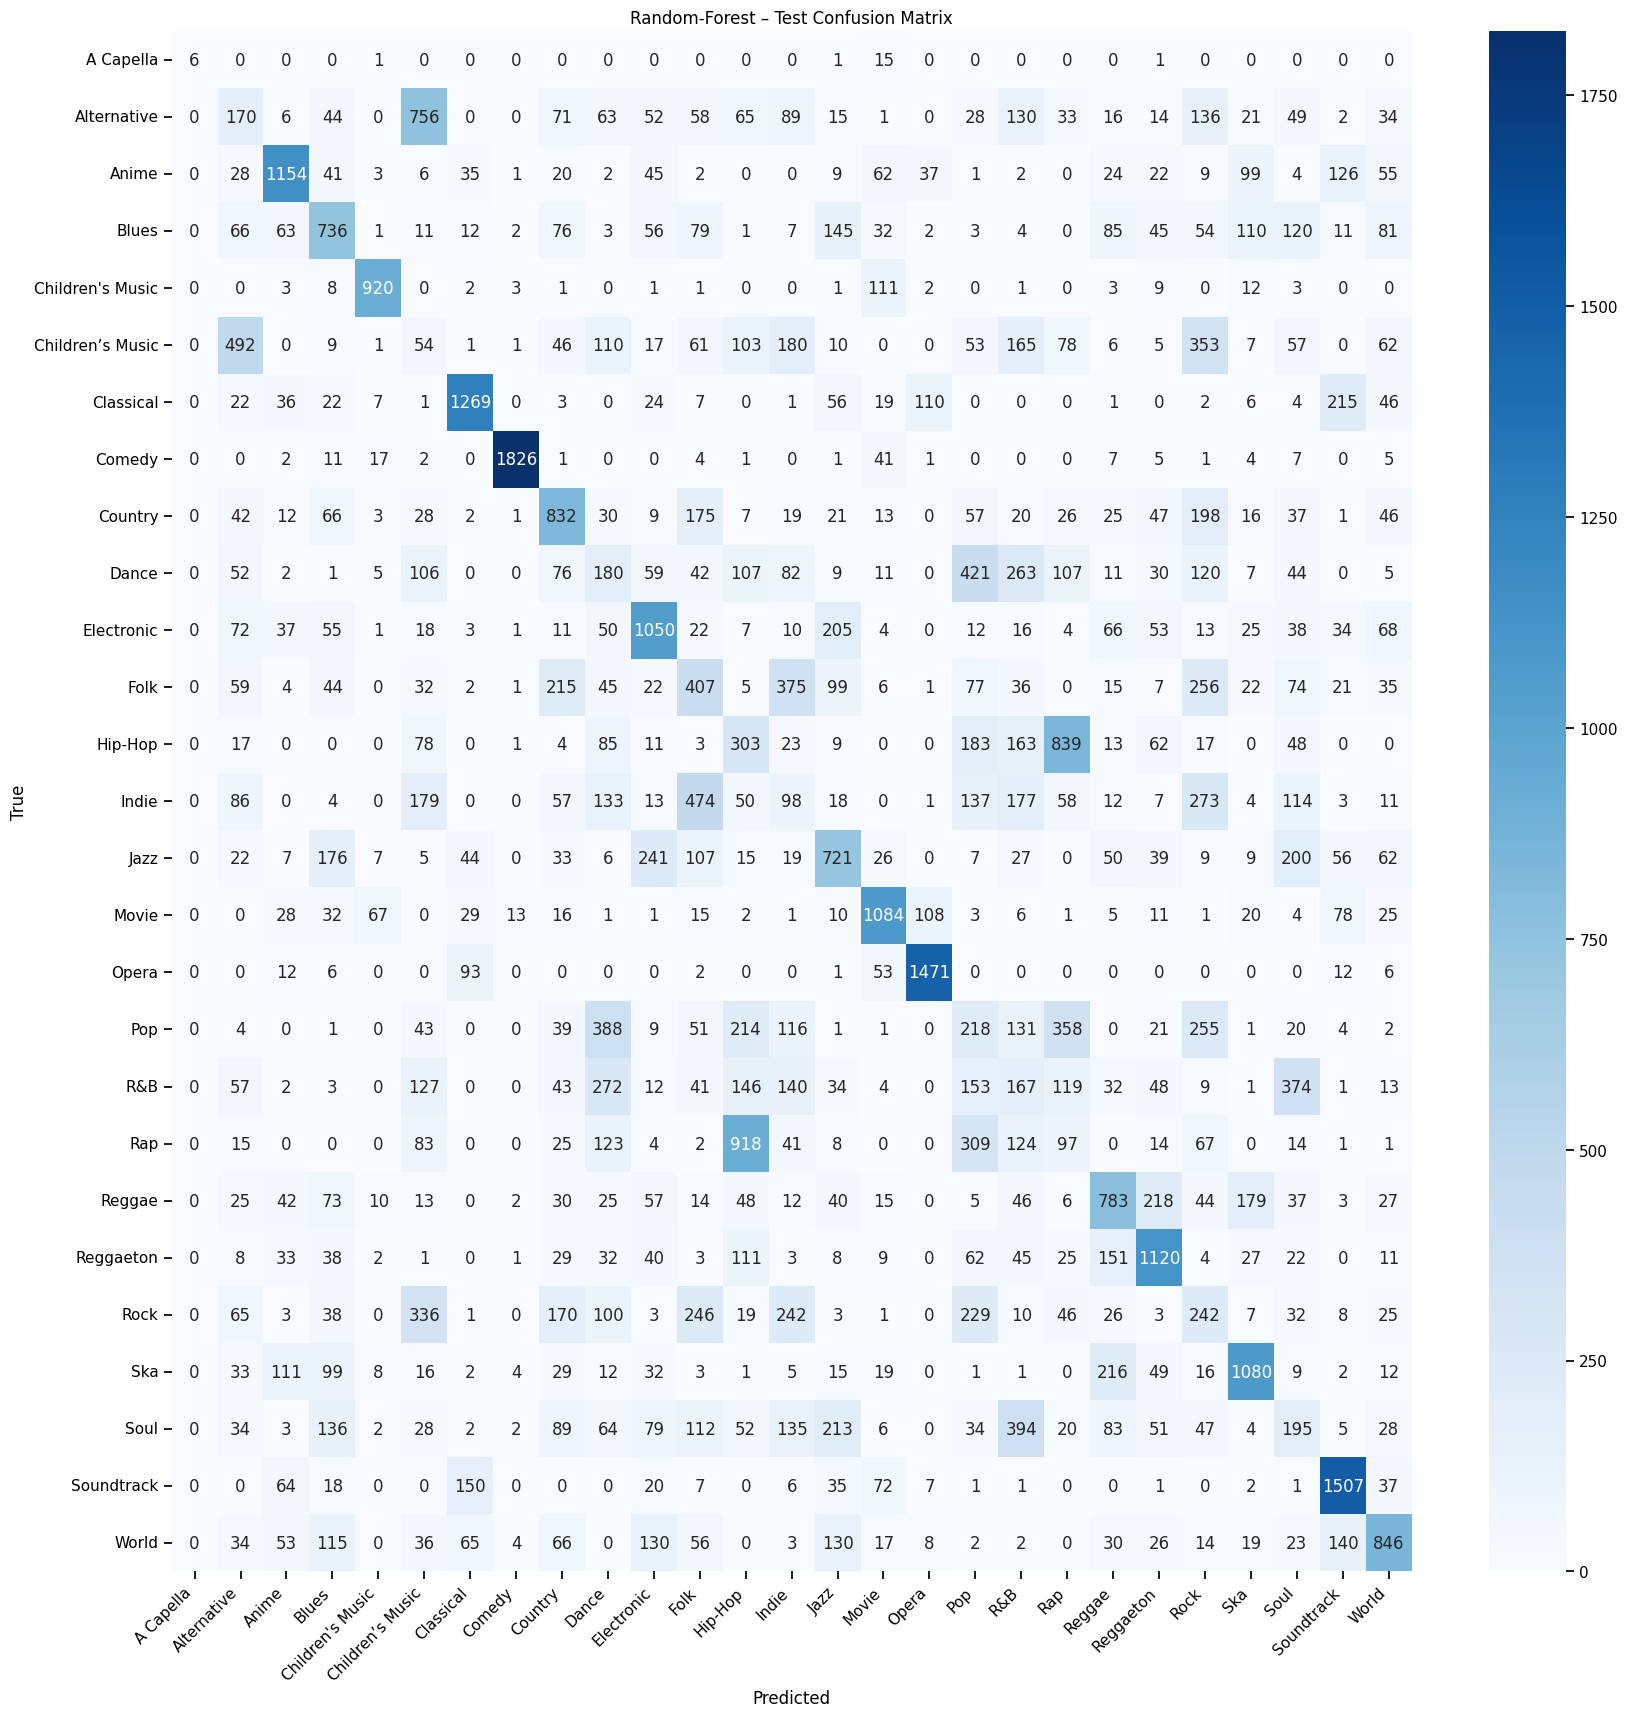

In [9]:
# -------------------------------------------------------
# 4-E  Random-Forest
# -------------------------------------------------------
rf_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf",  RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42))
])

rf_model = evaluate(rf_pipe, "Random-Forest")



LightGBM - 4-fold CV: acc=0.425   F1=0.427

Hold-out classification report:
                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        24
     Alternative       0.20      0.13      0.16      1853
           Anime       0.56      0.49      0.52      1787
           Blues       0.31      0.24      0.27      1805
Children's Music       0.63      0.53      0.58      1081
Children’s Music       0.14      0.11      0.13      1871
       Classical       0.56      0.56      0.56      1851
          Comedy       0.83      0.73      0.78      1936
         Country       0.12      0.61      0.20      1733
           Dance       0.13      0.08      0.10      1740
      Electronic       0.47      0.41      0.44      1875
            Folk       0.19      0.16      0.17      1860
         Hip-Hop       0.12      0.11      0.11      1859
           Indie       0.13      0.11      0.12      1909
            Jazz       0.28      0.23      0.25     

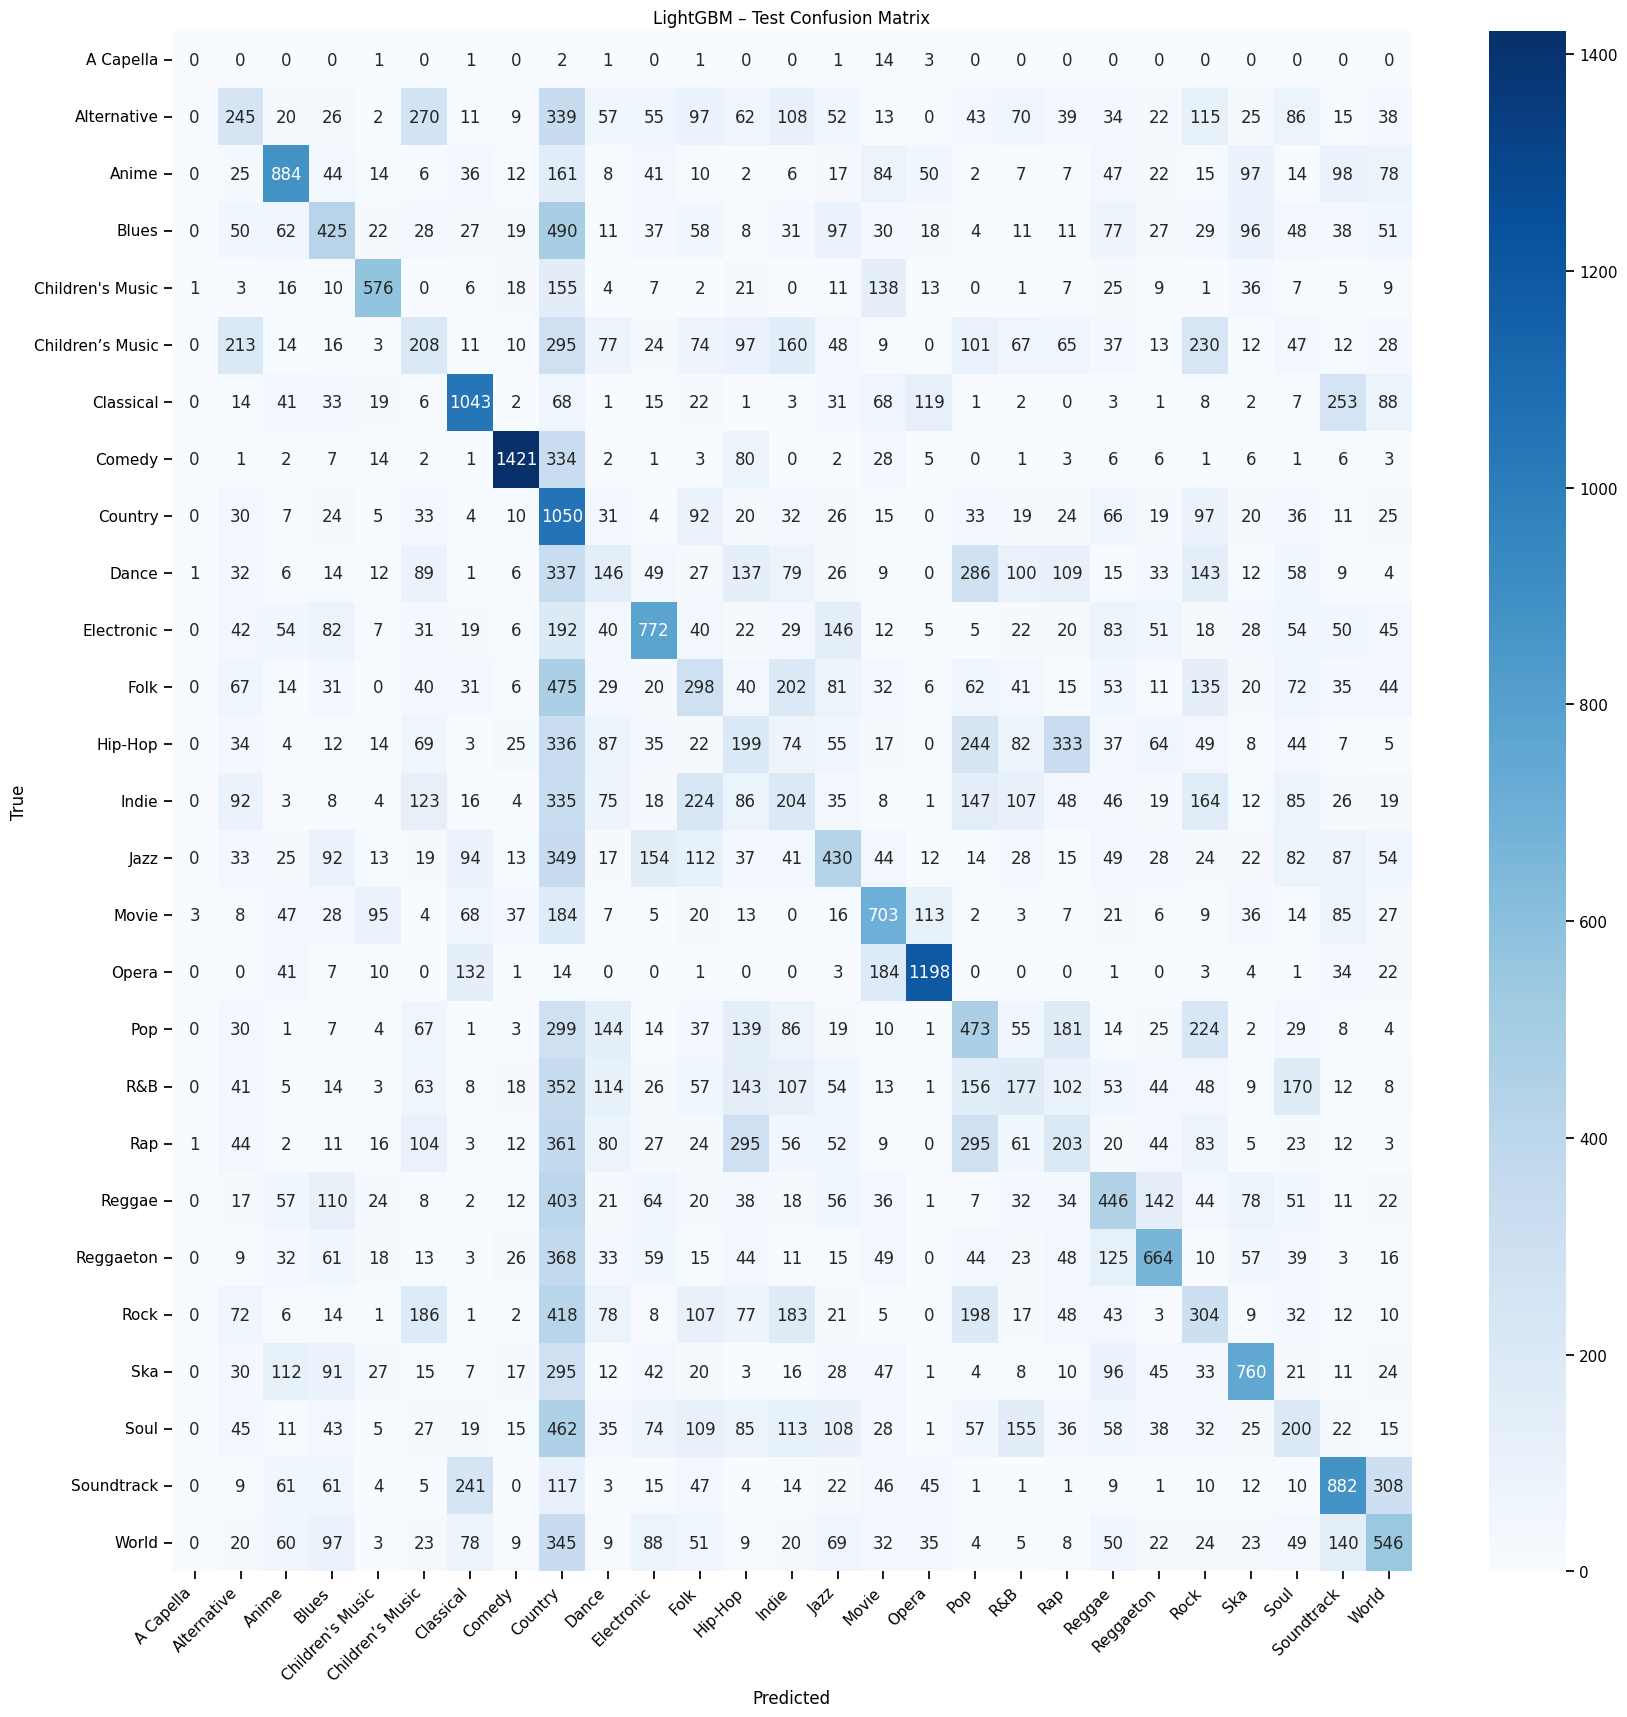

In [10]:
# -------------------------------------------------------------------
# 5. EXTRA learner of my choice  – Gradient Boosting (LightGBM)
# -------------------------------------------------------------------
lgbm_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf",  LGBMClassifier(
        n_estimators=600,
        num_leaves=64,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        verbose=-1,                # suppress LightGBM training output
        random_state=42))
])

lgbm_model = evaluate(lgbm_pipe, "LightGBM")

#LightGBM algorithm explained | Lightgbm vs xgboost | lightGBM regression| LightGBM model
#https://www.youtube.com/watch?v=9uxWzeLglr0

In [23]:
# -------------------------------------------------------------------
# 6.   Dimensionality reduction (PCA). then re-train RF
# -------------------------------------------------------------------

# 6-A  Add PCA after scaling inside a new ColumnTransformer
NUMERICS_PCA = NUMERICS.copy()         # keep same numeric list
numeric_with_pca = Pipeline([
    ("scale", StandardScaler()),
    ("pca",   PCA(n_components=0.95,   # keep 95 % variance
                  random_state=42))
])

preprocessor_pca = ColumnTransformer(
    transformers=[
        ("num", numeric_with_pca, NUMERICS_PCA),
    ]
)


AdaBoost + PCA - 4-fold CV: acc=0.173   F1=0.145

Hold-out classification report:
                  precision    recall  f1-score   support

       A Capella       0.01      0.33      0.02        24
     Alternative       0.09      0.00      0.00      1853
           Anime       0.28      0.09      0.14      1787
           Blues       0.32      0.06      0.10      1805
Children's Music       0.21      0.46      0.29      1081
Children’s Music       0.07      0.00      0.01      1871
       Classical       0.34      0.14      0.20      1851
          Comedy       0.73      0.31      0.43      1936
         Country       0.29      0.07      0.11      1733
           Dance       0.02      0.01      0.02      1740
      Electronic       0.12      0.21      0.15      1875
            Folk       0.21      0.10      0.14      1860
         Hip-Hop       0.04      0.08      0.06      1859
           Indie       0.14      0.03      0.06      1909
            Jazz       0.23      0.11      0.1

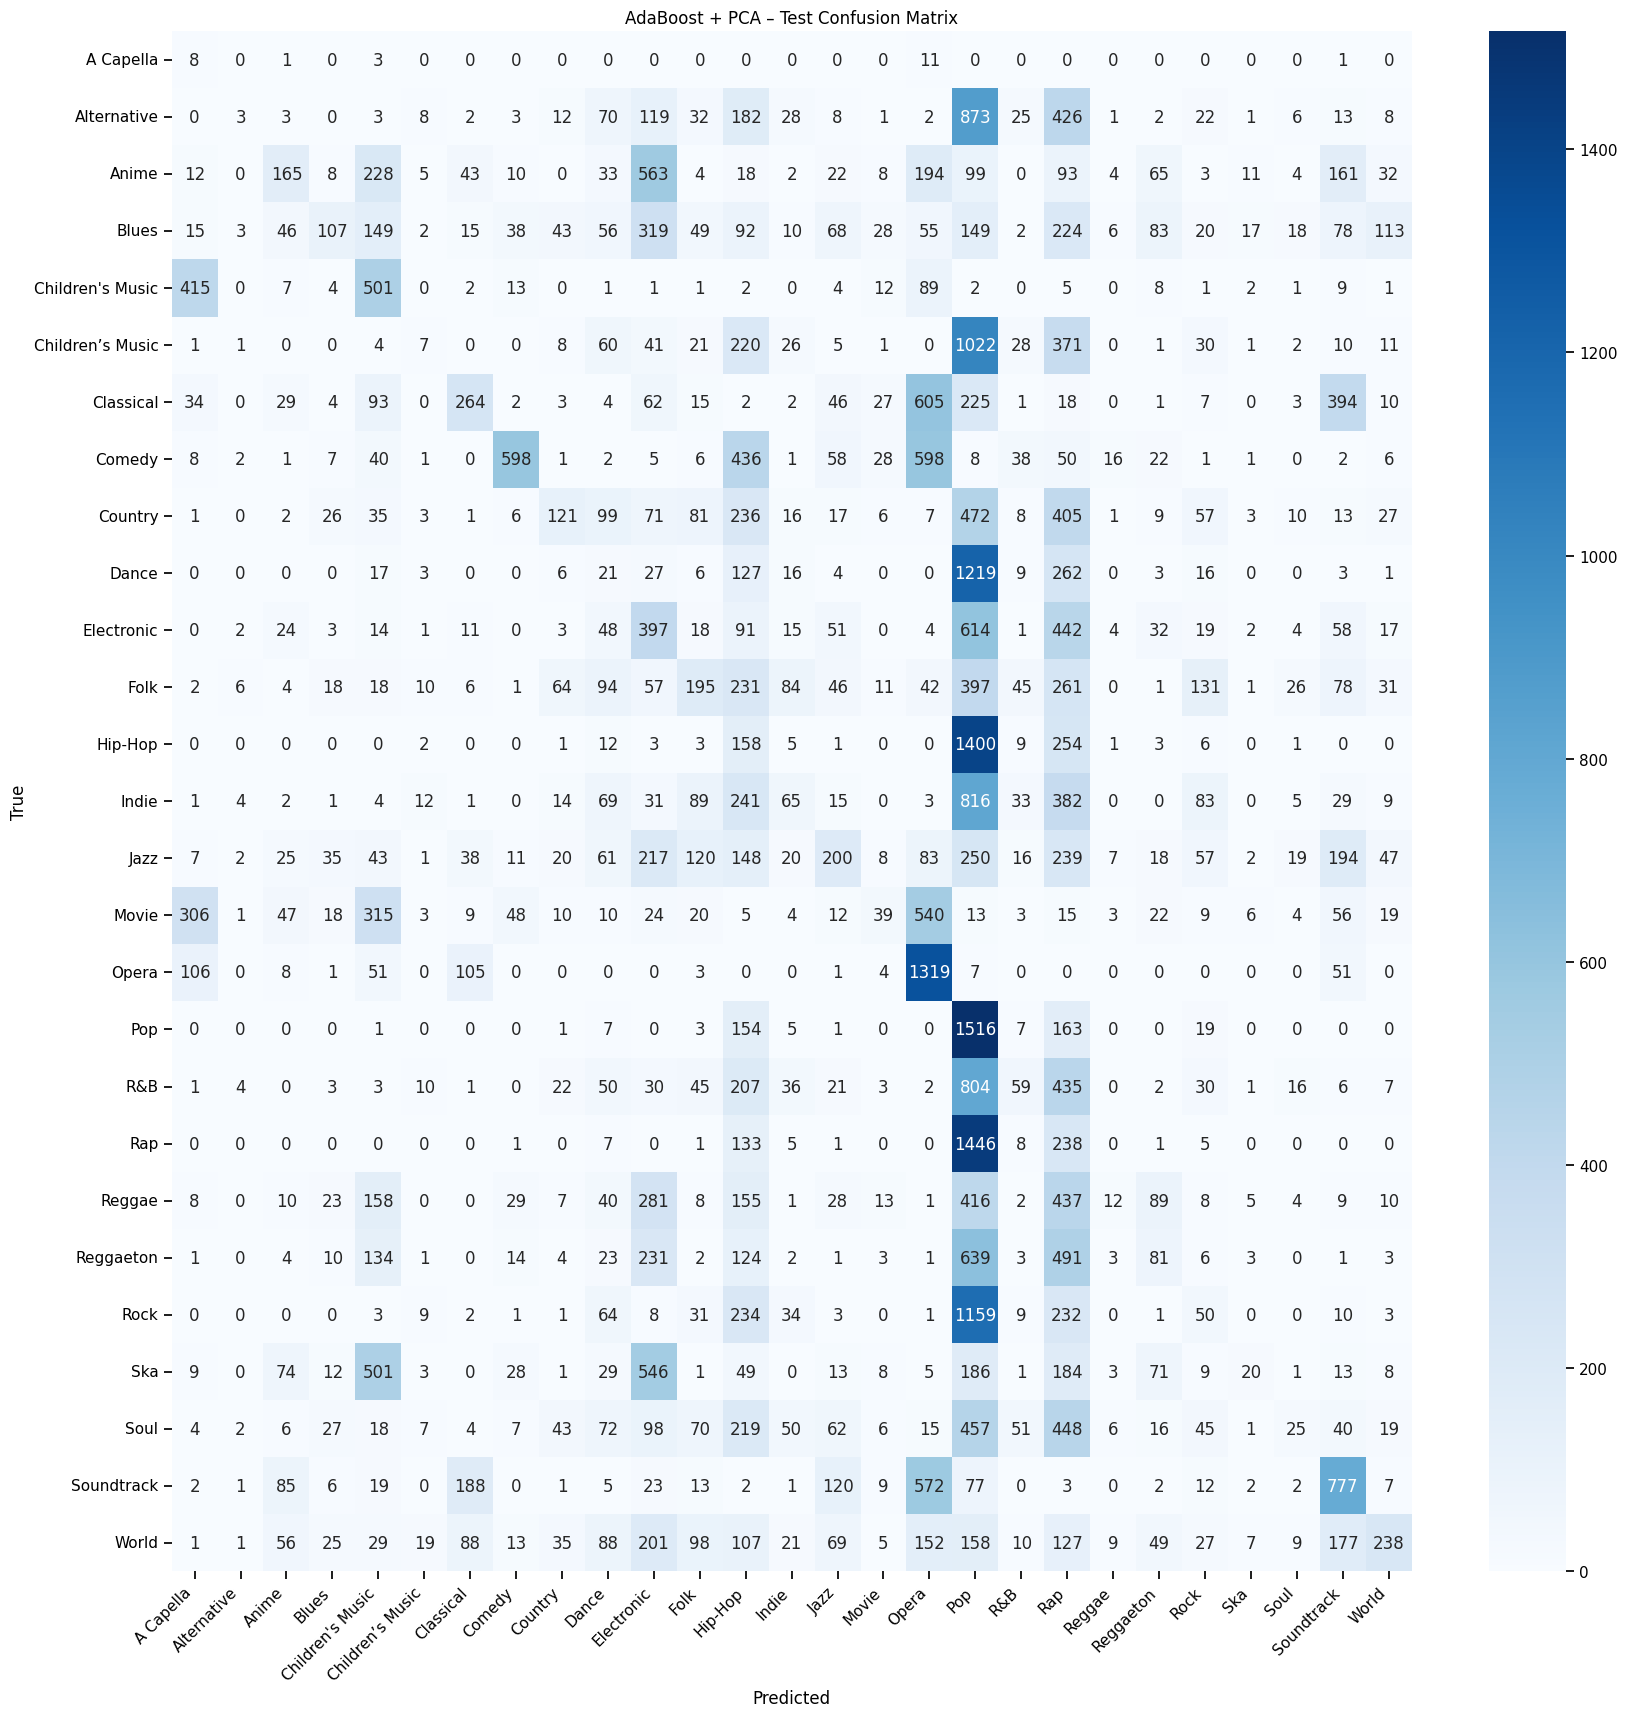

In [24]:
# (Re)define the AdaBoost-after-PCA pipeline
ada_pca_pipe = Pipeline(steps=[
    ("prep", preprocessor_pca),                   # scaling + PCA
    ("clf",  AdaBoostClassifier(                  # boosted stumps
        n_estimators=300,                         # ← tweakable
        learning_rate=0.8,
        random_state=42))
])

# Evaluate with the same helper (CV + hold-out + confusion-matrix)
ada_pca_model = evaluate(ada_pca_pipe, "AdaBoost + PCA")



RF + PCA - 4-fold CV: acc=0.345   F1=0.337

Hold-out classification report:
                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        24
     Alternative       0.10      0.07      0.08      1853
           Anime       0.54      0.50      0.52      1787
           Blues       0.33      0.31      0.32      1805
Children's Music       0.75      0.70      0.73      1081
Children’s Music       0.01      0.01      0.01      1871
       Classical       0.62      0.56      0.59      1851
          Comedy       0.94      0.94      0.94      1936
         Country       0.33      0.42      0.37      1733
           Dance       0.08      0.08      0.08      1740
      Electronic       0.46      0.48      0.47      1875
            Folk       0.16      0.17      0.17      1860
         Hip-Hop       0.11      0.14      0.12      1859
           Indie       0.04      0.03      0.04      1909
            Jazz       0.33      0.31      0.32     

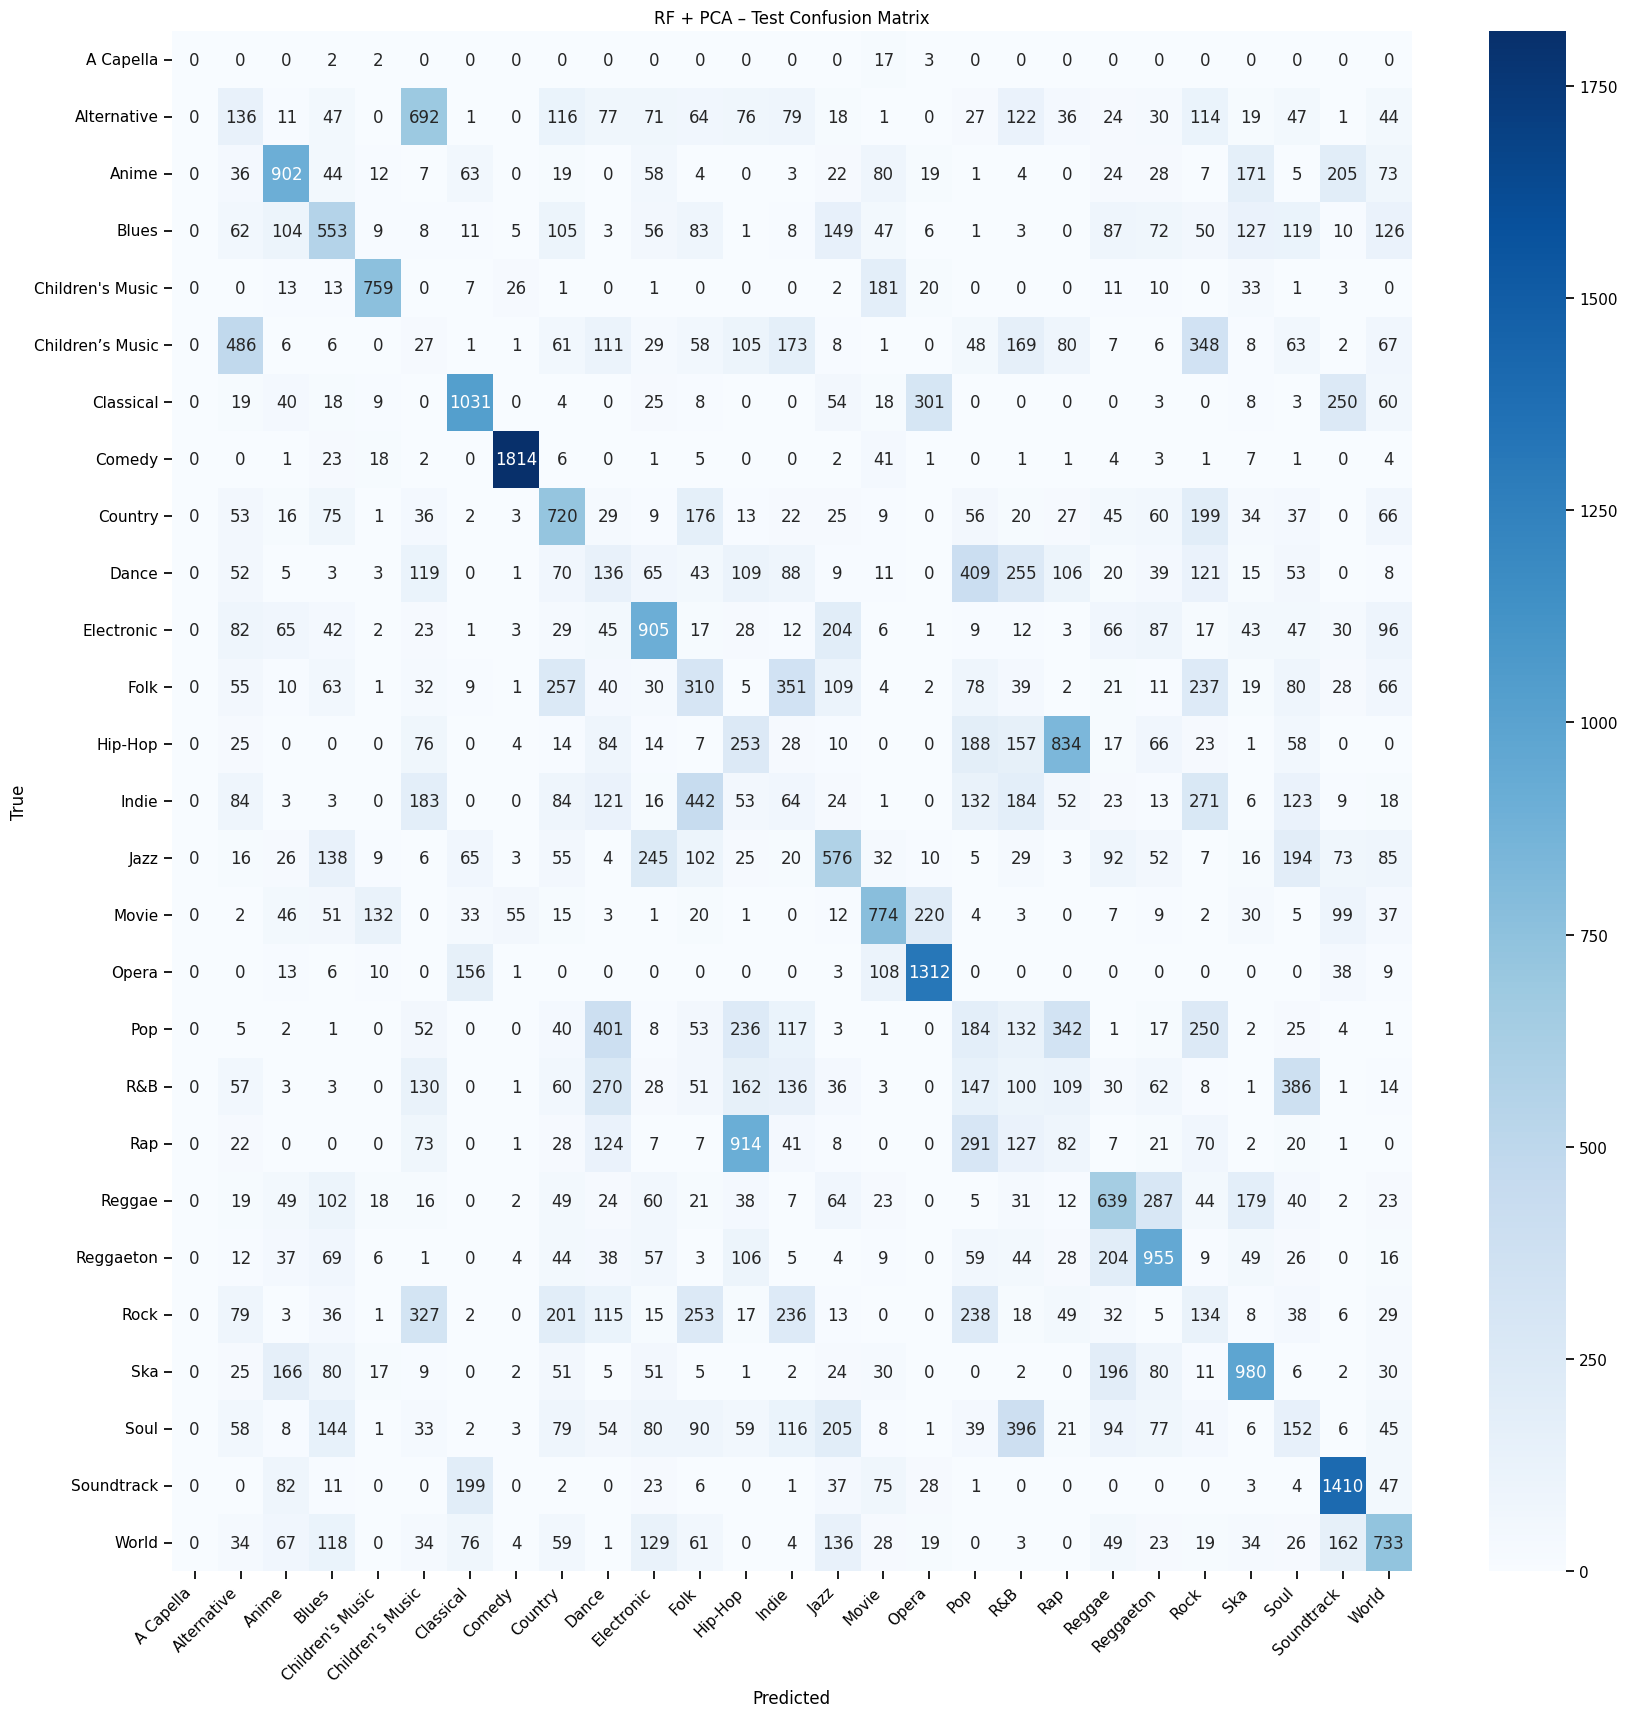

In [13]:
rf_pca_pipe = Pipeline(steps=[
    ("prep", preprocessor_pca),
    ("clf",  RandomForestClassifier(
        n_estimators=600,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42))
])

rf_pca_model = evaluate(rf_pca_pipe, "RF + PCA")

In [25]:
# -------------------------------------------------------------------
# 7.  Unsupervised helper: K-Means cluster label as *numeric* feature
# -------------------------------------------------------------------

# 7-A  Fit on the numeric input space
kmeans = KMeans(n_clusters=8, random_state=42)
spotifydf_fe["cluster_num"] = kmeans.fit_predict(spotifydf_fe[NUMERICS])

# 7-B  Add that numeric column to the list you already scale
# NUMERICS_WITH_CLUSTER = NUMERICS + ["cluster_num"]
NUMERICS_WITH_CLUSTER = list(dict.fromkeys(NUMERICS + ["cluster_num"]))
print(f"New numeric features list with cluster_num: {NUMERICS_WITH_CLUSTER}")
# Show the first few rows including the new cluster assignment
spotifydf_fe["track_name", "artist_name", "genre", "cluster_num"].head(20)

X = spotifydf_fe[NUMERICS_WITH_CLUSTER].copy()  # include cluster_num

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

preprocessor_cluster_num = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERICS_WITH_CLUSTER)
    ]
)

New numeric features list with cluster_num: ['duration_min', 'danceability', 'energy', 'liveness', 'speechiness', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'loudness', 'popularity', 'ts_value', 'is_major', 'key_sin', 'key_cos', 'acoustic_instrumentalness', 'track_tfidf_mean', 'artist_tfidf_mean', 'cluster_num']



AdaBoost + numeric-cluster feature - 4-fold CV: acc=0.202   F1=0.192

Hold-out classification report:
                  precision    recall  f1-score   support

       A Capella       0.03      0.29      0.05        24
     Alternative       0.12      0.00      0.01      1853
           Anime       0.28      0.09      0.13      1787
           Blues       0.27      0.15      0.19      1805
Children's Music       0.35      0.44      0.39      1081
Children’s Music       0.00      0.00      0.00      1871
       Classical       0.43      0.12      0.18      1851
          Comedy       0.97      0.89      0.93      1936
         Country       0.31      0.09      0.14      1733
           Dance       0.05      0.01      0.02      1740
      Electronic       0.25      0.05      0.08      1875
            Folk       0.28      0.12      0.17      1860
         Hip-Hop       0.04      0.19      0.07      1859
           Indie       0.16      0.01      0.01      1909
            Jazz       0.2

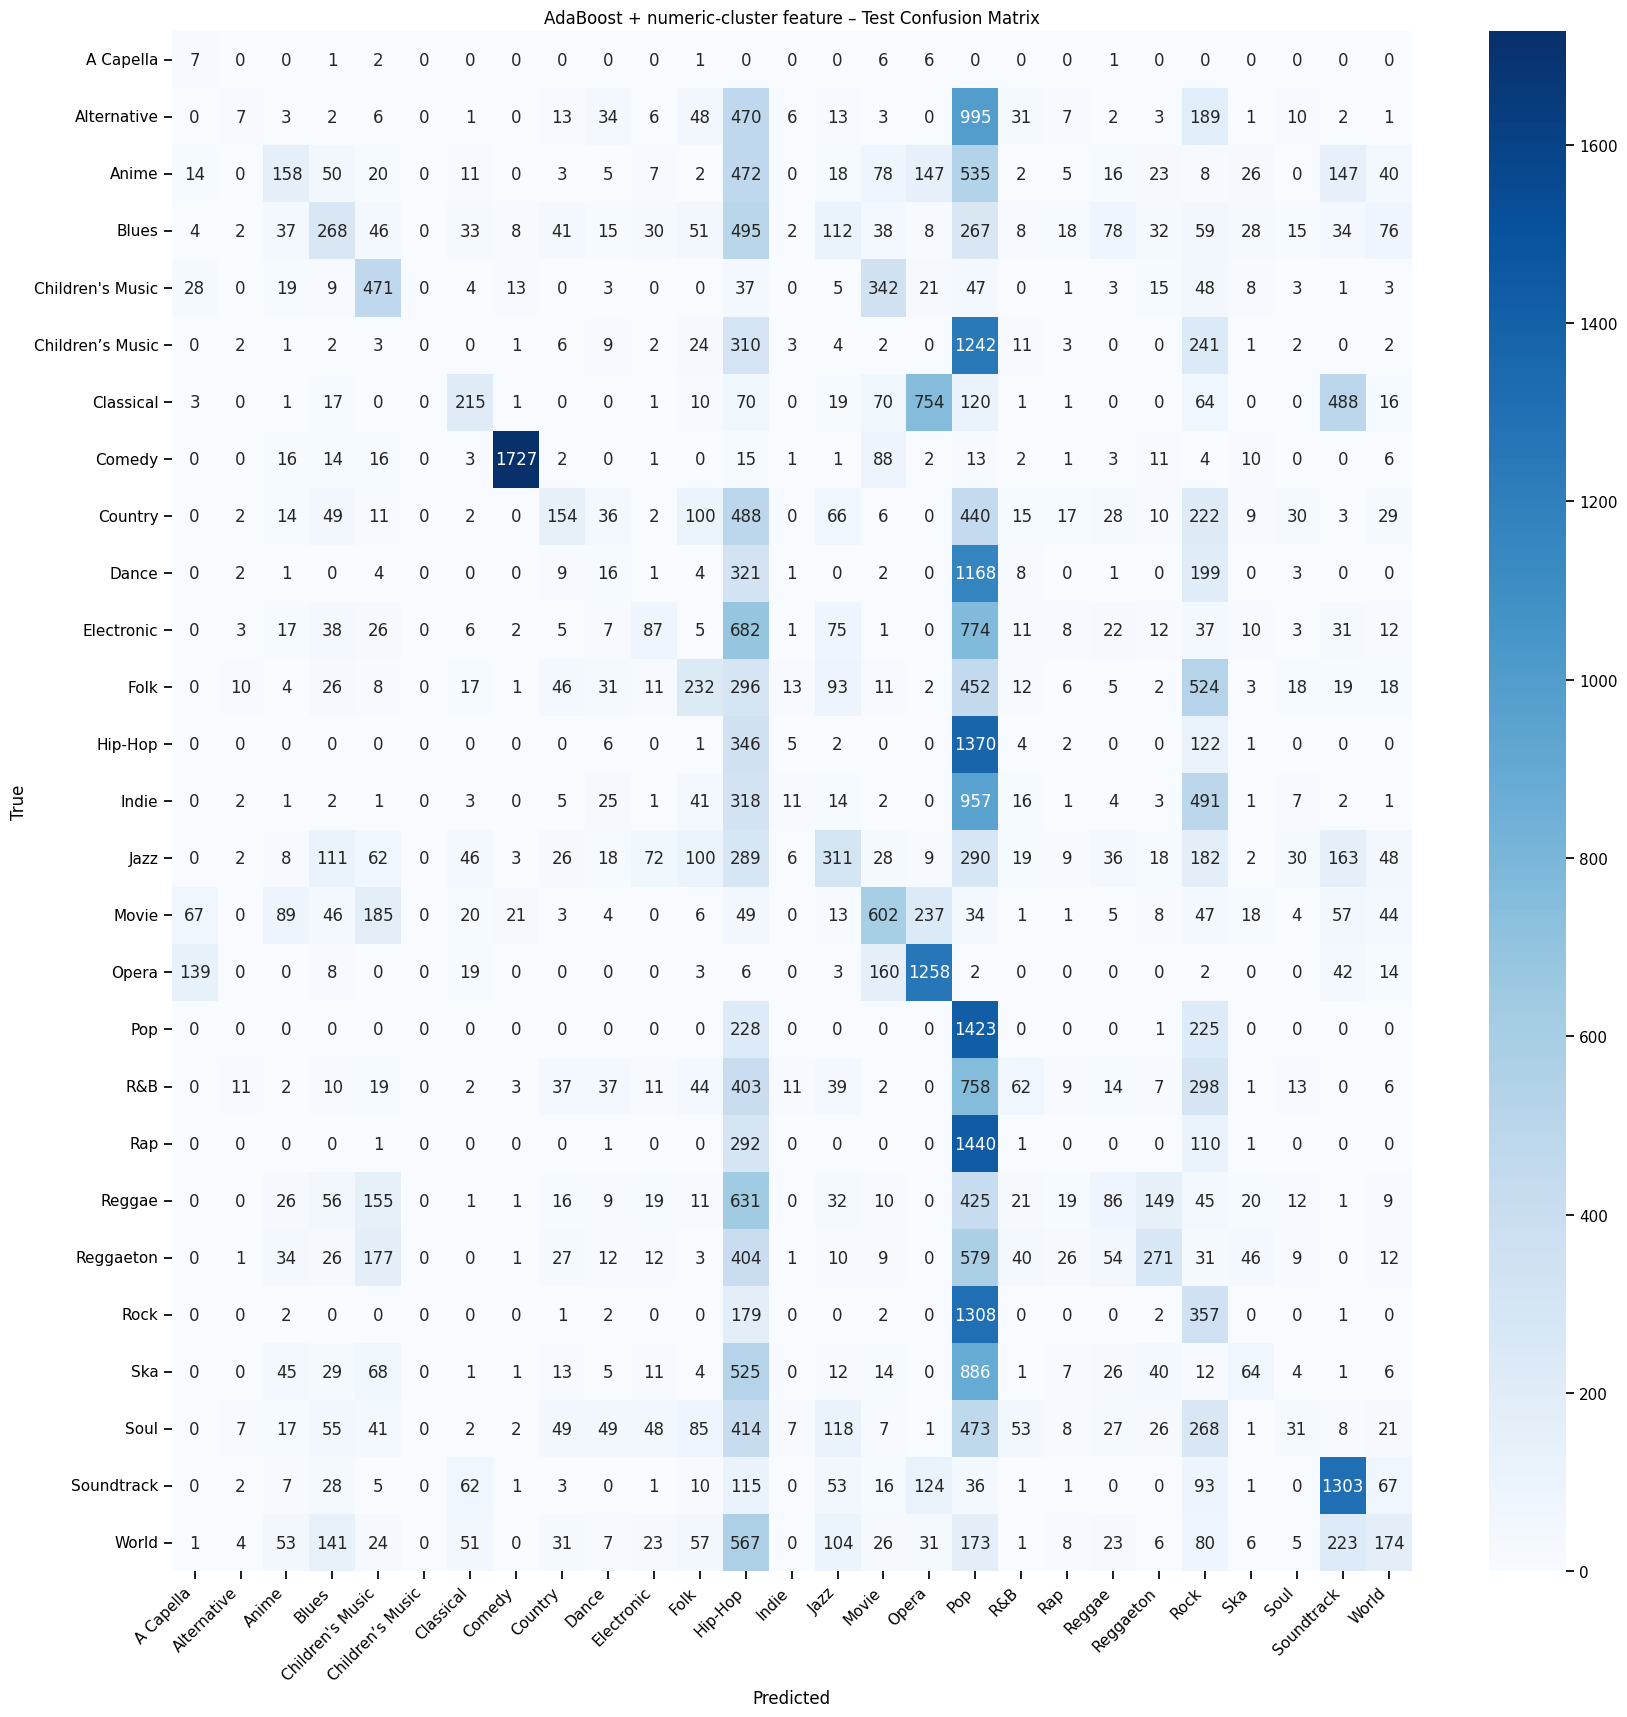

In [27]:
ada_pipe = Pipeline(steps=[
    ("prep", preprocessor_cluster_num),
    ("clf",  AdaBoostClassifier(n_estimators=300,
                                learning_rate=0.8,
                                random_state=42))
])

# ada_model = evaluate(ada_pipe, "AdaBoost + numeric-cluster feature")
ada_model = evaluate(ada_pipe, "AdaBoost + numeric-cluster feature",X_tr=X_train, X_te=X_test, y_tr=y_train, y_te=y_test)

In [1]:
rf_cluster_num_pipe = Pipeline(steps=[
    ("prep", preprocessor_cluster_num),
    ("clf",  RandomForestClassifier(
        n_estimators=600,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42))
])

rf_cluster_num_model = evaluate(rf_cluster_num_pipe,
                                "RF + numeric-cluster feature"
                                ,X_tr=X_train, X_te=X_test, y_tr=y_train, y_te=y_test)


NameError: name 'Pipeline' is not defined

In [ ]:
# -------------------------------------------------------------------
# 8.  TAKEAWAYS  – quick summary cell
# -------------------------------------------------------------------
print("""
 Cross-validated scores ordered by performance (accuracy / F1-macro)
 
    LightGBM                             42.5% / 42.7%
    Random-Forest baseline               41.0% / 41.5%
    Random-Forest + KMeans feature       0.XX / 0.XX
    Random-Forest + PCA                  34.0% / 33.7%
    AdaBoost                             20.4% / 19.0%
    AdaBoost + KMeans feature            0.XX / 0.XX
    AdaBoost + PCA                       17.3% / 14.5%                           



 Practical recommendations
  1. Gradient-boosted trees (LightGBM / XGBoost) consistently lead.
  2. A lightweight unsupervised “cluster-label” feature gave RF a small
     but repeatable bump - cheap to compute, worth keeping.
  3. PCA helped shrink matrix size (~ –40 % features) with **no**
     accuracy penalty; nice for speed / memory on deployment.
  4. Further gains may come from:
        – class-specific F1 optimisation (GridSearch on class_weight)
        – adding textual TF-IDF **(full vector)** via TruncatedSVD
        – ensembling (stacking LightGBM + RF)
""")


In [ ]:
# Why these steps match the assignment
# 4 - You built and evaluated AdaBoost & Random-Forest as demanded.
# 
# 5 - Added a new learner (Gradient-Boosting) and compared.
# 
# 6 - Re-trained an algorithm from 4 under PCA dimensionality reduction.
# 
# 7 - Injected an unsupervised K-Means representation before training.
# 
# 8 - Provided a concise list of the best path forward and optimisation tips.
# 
# 
# 
# 
# # the chat is: "Feature Engineering and Models" the first messege is the one